In [56]:
import numpy as np
import torch                 #导入库和画图工具
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [57]:

epochs = 10000    # 训练代数
h = 100    # 画图网格密度
N = 1000    # 内点配置点数
N1 = 100    # 边界点配置点数
N2 = 1000    # PDE数据点
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    # 保证每次运行结果一样
    # 在神经网络中，参数默认是进行随机初始化的。
    #如果不设置的话每次训练时的初始化都是随机的，导致结果不确定。
    #如果设置初始化，则每次初始化都是固定的。

# 设置随机数种子  设定固定的随机数以便结果可以复现
setup_seed(777)

In [58]:

# Domain and Sampling
def interior(n=N):
    # 内点
    t = (torch.rand(n, 1)*torch.e*4/5)
    x = (torch.rand(n, 1)*torch.e)
    cond = (torch.zeros_like(x))
    return t.requires_grad_(True), x.requires_grad_(True), cond

def up(n=N1):
    x = (torch.rand(n, 1)*torch.e)
    t = (torch.ones_like(x)*torch.e*4/5)
    cond = torch.sin(3*torch.pi/(2*torch.e)*x)*torch.cos(torch.tensor(6*torch.pi/5))
    return x.requires_grad_(True), t.requires_grad_(True), cond


def down(n=N1):
    x = (torch.rand(n, 1)*torch.e)
    t = (torch.zeros_like(x))
    cond = torch.sin(3*torch.pi/(2*torch.e)*x)
    return x.requires_grad_(True), t.requires_grad_(True), cond

def left(n=N1):
    t = (torch.rand(n, 1)*torch.e*4/5)
    x = (torch.zeros_like(t))
    cond = torch.zeros_like(x)
    return x.requires_grad_(True), t.requires_grad_(True), cond


def right_x(n=N1):
    t = (torch.rand(n, 1)*torch.e*4/5)
    x = (torch.ones_like(t)*torch.e)
    cond = torch.zeros_like(x)
    return x.requires_grad_(True), t.requires_grad_(True), cond


In [59]:

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)



In [60]:

# 损失函数使用MSE 均方方差 每个数据点所产生的方差的平均值 
#  https://zhuanlan.zhihu.com/p/35707643

def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   create_graph=True,
                                   only_inputs=True, )[0]
    else:
        return gradients(gradients(u, x), x, order=order - 1)
    
    
    
    
# Training
u = MLP()
optimizer = torch.optim.Adam(params=u.parameters())
criterion = torch.nn.MSELoss()




In [61]:

# 以下7个损失是PDE损失
def l_interior(u):
    # 损失函数L1
    x, t, cond = interior()
    uxt = u(torch.cat([x, t], dim=1))
    return criterion(gradients(uxt, t, 2) - gradients(uxt, x, 2), cond)

def l_up(u):
    # 损失函数L2
    x, t, cond = up_t()
    uxt = u(torch.cat([x, t], dim=1))
    return criterion(uxt, cond)

def l_down(u):
    # 损失函数L3
    x, t, cond = down()
    uxt = u(torch.cat([x, t], dim=1))
    return criterion(uxt, cond)

def l_left(u):
    # 损失函数L4
    x, t, cond = left()
    uxt = u(torch.cat([x, t], dim=1))
    return criterion(uxt, cond)

def l_right_x(u):
    # 损失函数L5
    x, t, cond = right_x()
    uxt = u(torch.cat([x, t], dim=1))
    return criterion(gradients(uxt, x, 1), cond)








loses = []


In [62]:
for i in range(epochs):
    optimizer.zero_grad()
    #  将这一轮的梯度清零，防止其影响下一轮的更新
    loss = l_interior(u) + l_up(u) + l_down(u) + l_left(u) + l_right_x(u) 
    loss.backward()
    # 反向计算出各参数的梯度
    optimizer.step()
    
    if i % 100 == 0:
        print(i)
    
    loses.append(loss.item())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [63]:
loses

[0.6494896411895752,
 0.6436688899993896,
 0.6763370037078857,
 0.6044013500213623,
 0.563845694065094,
 0.5567947030067444,
 0.5736103057861328,
 0.5982375741004944,
 0.5156705975532532,
 0.5563675165176392,
 0.5650311708450317,
 0.5438233613967896,
 0.5170777440071106,
 0.48857542872428894,
 0.5533251166343689,
 0.5507943630218506,
 0.5293336510658264,
 0.5288320183753967,
 0.5520653128623962,
 0.4990832507610321,
 0.5433229804039001,
 0.538630485534668,
 0.5538167953491211,
 0.47947871685028076,
 0.4689949154853821,
 0.45248275995254517,
 0.48589956760406494,
 0.43038028478622437,
 0.517620325088501,
 0.46114474534988403,
 0.5098285675048828,
 0.5274372696876526,
 0.515385627746582,
 0.47472846508026123,
 0.49246945977211,
 0.47694650292396545,
 0.4691995680332184,
 0.458953857421875,
 0.4510388970375061,
 0.5185461044311523,
 0.4427897036075592,
 0.46528539061546326,
 0.43938398361206055,
 0.5026159882545471,
 0.5018395781517029,
 0.4485010802745819,
 0.46156272292137146,
 0.469235

In [64]:
# Inference
xc = torch.linspace(0, torch.e, h)
tc = torch.linspace(0, torch.e*4/5, h)

xm, tm = torch.meshgrid(xc,tc)

xx = xm.reshape(-1, 1)
tt = tm.reshape(-1, 1)
xt = torch.cat([xx, tt], dim=1)
u_pred = u(xt)
u_real = (torch.cos(3*torch.pi/(2*torch.e)*tt)*torch.sin(3*torch.pi/(2*torch.e)*xx) + (2*torch.e)/(5*torch.pi)*torch.sin(5*torch.pi/(2*torch.e)*tt)*torch.sin(5*torch.pi/(2*torch.e)*xx))
u_error = torch.abs(u_pred-u_real)
u_pred_fig = u_pred.reshape(h,h)
u_real_fig = u_real.reshape(h,h)
u_error_fig = u_error.reshape(h,h)
print("Max abs error is: ", float(torch.max(u_error)))

Max abs error is:  0.8899982571601868


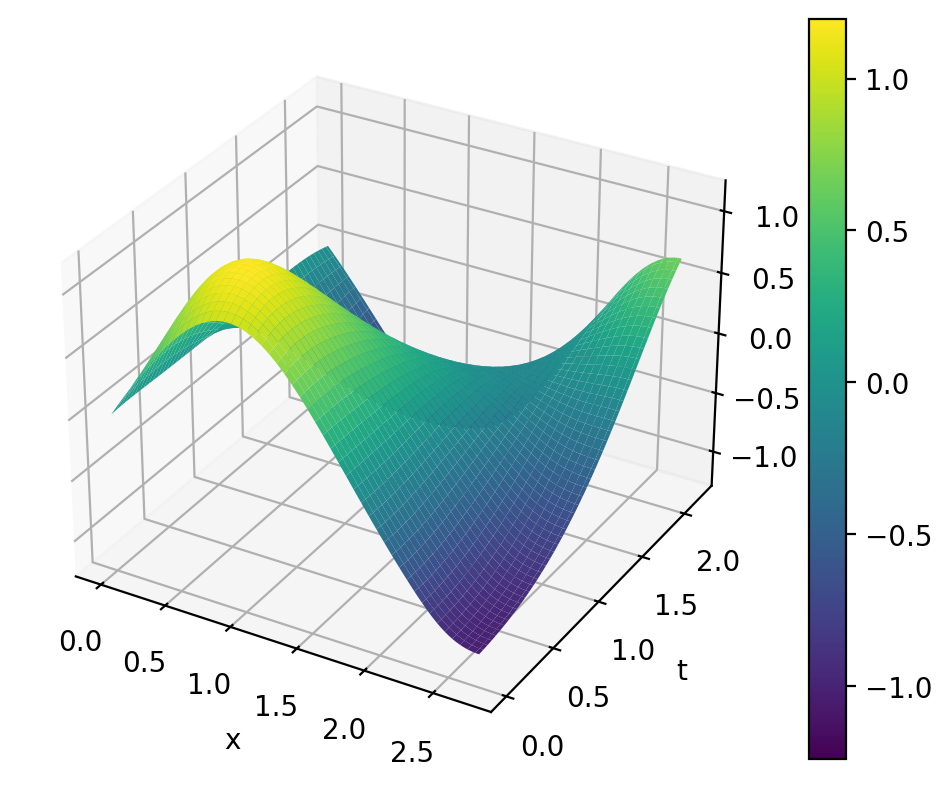

In [70]:

# 创建3D图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制surface图
surf = ax.plot_surface(xm.detach().numpy(), tm.detach().numpy(), u_pred_fig.detach().numpy(), cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')

# 添加颜色条
fig.colorbar(surf)

# 显示图形
plt.show()

In [66]:
u_pred_fig.detach().numpy()[:,0]

array([ 0.00211543,  0.04949841,  0.09630074,  0.14250156,  0.18808545,
        0.23303545,  0.27733558,  0.32096684,  0.36390597,  0.40612665,
        0.4475964 ,  0.48827305,  0.5281102 ,  0.5670503 ,  0.6050277 ,
        0.6419665 ,  0.677785  ,  0.7123893 ,  0.74568015,  0.77755255,
        0.80789393,  0.83659154,  0.86352724,  0.8885876 ,  0.91165835,
        0.9326306 ,  0.9514021 ,  0.9678778 ,  0.9819726 ,  0.99361354,
        1.0027363 ,  1.0092932 ,  1.0132486 ,  1.0145789 ,  1.0132785 ,
        1.0093496 ,  1.002813  ,  0.99369997,  0.9820523 ,  0.96792483,
        0.95138204,  0.93249804,  0.91135263,  0.8880363 ,  0.8626433 ,
        0.8352745 ,  0.80603236,  0.7750258 ,  0.7423636 ,  0.7081576 ,
        0.67251927,  0.63556015,  0.59739226,  0.55812585,  0.5178682 ,
        0.4767248 ,  0.43480146,  0.3921942 ,  0.34900364,  0.30532092,
        0.26123634,  0.21683498,  0.1721991 ,  0.12740663,  0.08253156,
        0.03764513, -0.0071864 , -0.05190033, -0.09643528, -0.14

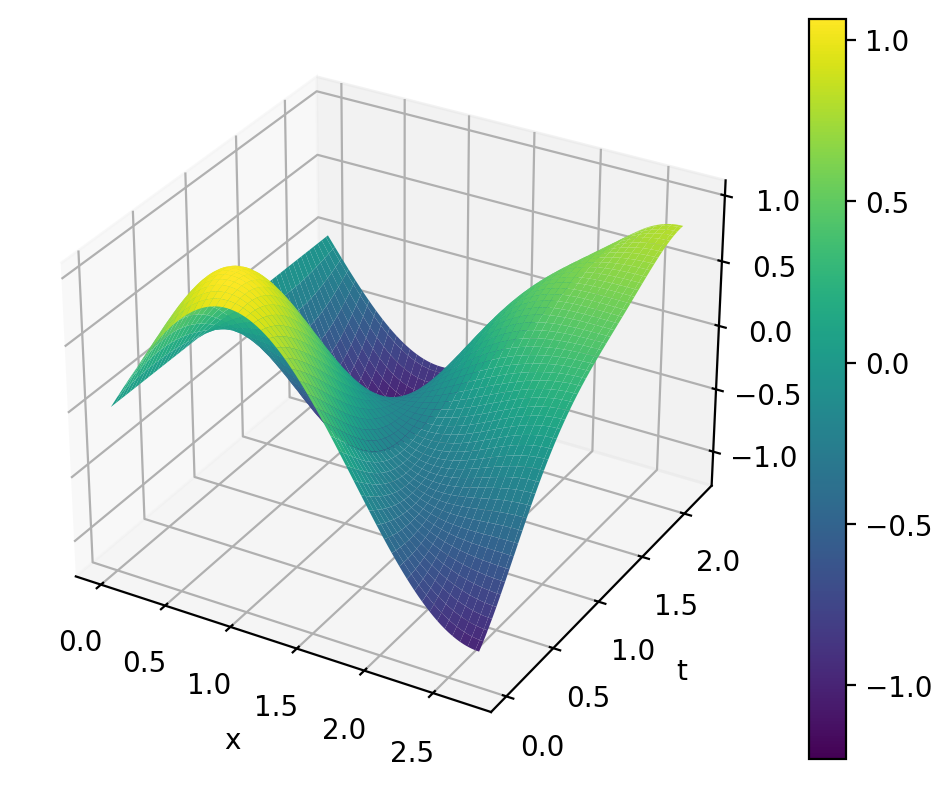

In [71]:
# 创建3D图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制surface图
surf = ax.plot_surface(xm.detach().numpy(), tm.detach().numpy(), u_real_fig.detach().numpy(), cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')


# 添加颜色条
fig.colorbar(surf)

# 显示图形
plt.show()

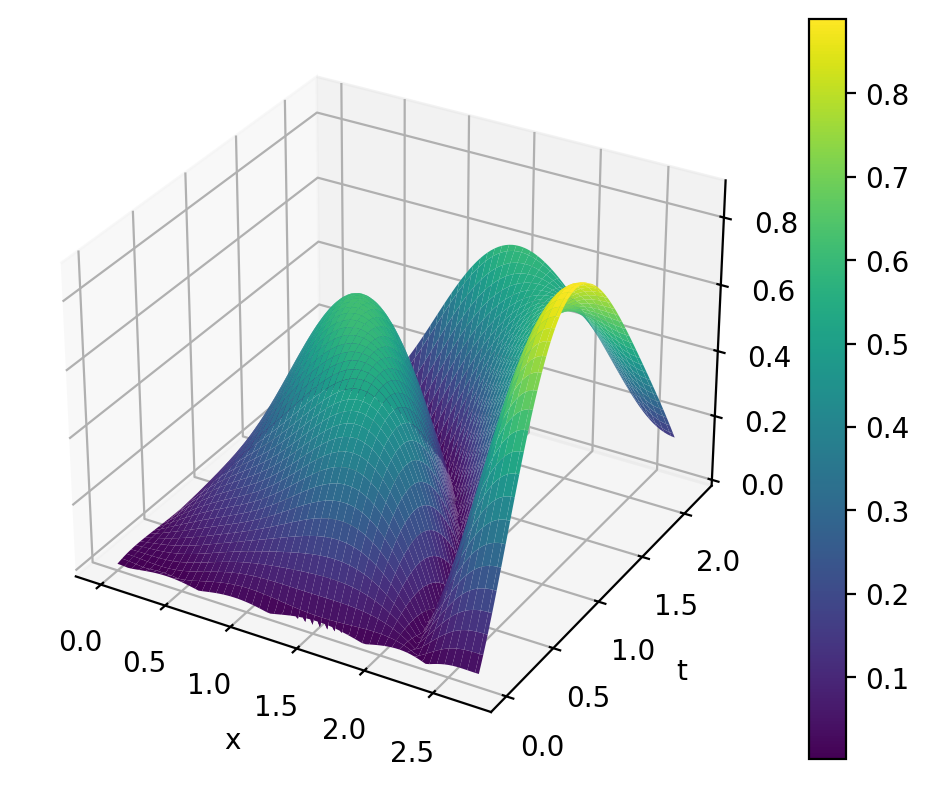

In [72]:
# 创建3D图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制surface图
surf = ax.plot_surface(xm.detach().numpy(), tm.detach().numpy(), u_error_fig.detach().numpy(), cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')


# 添加颜色条
fig.colorbar(surf)

# 显示图形
plt.show()